In [109]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [110]:
# read in pickled features
df_sj = pd.read_pickle('./datasets/all_sj.pkl')
df_iq = pd.read_pickle('./datasets/all_iq.pkl')

In [111]:
total_cases = pd.read_csv('./datasets/dengue_labels_train.csv')

In [112]:
cases_sj = total_cases[total_cases['city'] == 'sj']['total_cases']
cases_iq = total_cases[total_cases['city'] == 'iq']['total_cases']

In [113]:
# create month variable
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month

#all the dataset is loaded at once to improve the mean below.
# create mean ndvi
df_sj['ndvi_mean'] = (df_sj['ndvi_ne'] + df_sj['ndvi_nw'] + df_sj['ndvi_se'] + df_sj['ndvi_sw']) / 4.0

df_iq['ndvi_mean'] = (df_iq['ndvi_ne'] + df_iq['ndvi_nw'] + df_iq['ndvi_se'] + df_iq['ndvi_sw']) / 4.0

In [114]:
# get monthly trend of whole test df
df_sj2 =df_sj.reset_index(drop=True)
X_months = pd.get_dummies(df_sj2['month'], prefix='month')[:936]
Xtest_months = pd.get_dummies(df_sj2['month'], prefix='month')[936:]
#y = cases_sj.values

In [115]:
formula = ' + '.join([str(i) for i in list(X_months.columns)])
formula = 'y ~ ' + formula
print formula
X_months['y'] = cases_sj
X_months.head()

y ~ month_1 + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + month_11 + month_12


,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,y
0,0,0,0,1,0,0,0,0,0,0,0,0,4
1,0,0,0,0,1,0,0,0,0,0,0,0,5
2,0,0,0,0,1,0,0,0,0,0,0,0,4
3,0,0,0,0,1,0,0,0,0,0,0,0,3
4,0,0,0,0,1,0,0,0,0,0,0,0,6


In [116]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
modelSJ = smf.glm(formula=formula,
                data=X_months,
                family=sm.families.NegativeBinomial())
modelSJ= modelSJ.fit()

In [117]:
monthly_trend = pd.Series(modelSJ.predict(X_months)).rolling(3, min_periods=1).mean()
monthly_trend

0      10.022222
1      10.580556
2      10.766667
3      11.138889
4      11.138889
5      12.865741
6      14.592593
7      16.319444
8      16.319444
9      19.998148
10     23.676852
11     27.355556
12     27.355556
13     27.355556
14     34.250926
15     41.146296
16     48.041667
17     48.041667
18     50.611111
19     53.180556
20     55.750000
21     55.750000
22     60.833333
23     65.916667
24     71.000000
25     71.000000
26     71.000000
27     67.939815
28     64.879630
29     61.819444
         ...    
906    60.833333
907    65.916667
908    71.000000
909    71.000000
910    71.000000
911    67.939815
912    64.879630
913    61.819444
914    61.819444
915    55.106481
916    48.393519
917    41.680556
918    41.680556
919    38.261111
920    34.841667
921    31.422222
922    31.422222
923    31.422222
924    27.980556
925    24.538889
926    21.097222
927    21.097222
928    18.930556
929    16.763889
930    14.597222
931    14.597222
932    13.072222
933    11.5472

In [118]:
y = cases_sj.values
sj_residuals_all = y - monthly_trend



In [119]:
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[52:936]
Xtrain_means2 = df_sj['reanalysis_specific_humidity_g_per_kg'].rolling(window = 52).mean()[52:936]
Xtrain_means3 = df_sj['reanalysis_dew_point_temp_k'].rolling(window = 52).mean()[52:936]
Xtrain_means4 = df_sj['ndvi_se'].rolling(window = 25).mean()[52:936]
#print(Xtrain_means2)

# create test df of rolling weather stats
# rolling means df

In [120]:
# combine all dfs
Xtrain = pd.concat([Xtrain_means1,Xtrain_means2,Xtrain_means3], axis = 1)

In [121]:
ytrain = sj_residuals_all [52:]

# create test df on rolllr_sj_residing weather stats
# rolling means df
Xtest_means1 = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[936:]
Xtest_means2 = df_sj['reanalysis_specific_humidity_g_per_kg'].rolling(window = 52).mean()[936:]
Xtest_means3 = df_sj['reanalysis_dew_point_temp_k'].rolling(window = 52).mean()[936:]
Xtest_means4 = df_sj['ndvi_se'].rolling(window = 25).mean()[936:]


In [122]:
# combine all dfs
Xtest_weather = pd.concat([Xtest_means1,Xtest_means2,Xtest_means3], axis = 1)

#Xtest_weather[Xtest_weather.columns] = scaler.fit_transform(Xtest_weather)


In [123]:
# fit on model
formula = ' + '.join([str(i) for i in list(Xtrain.columns)])
formula = 'y ~ ' + formula
print formula

y ~ station_avg_temp_c + reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k


In [126]:
ytrain
ytrain =ytrain.reset_index(drop=True)

In [129]:
Xtrain['y'] =  ytrain
#Xtrain =Xtrain.reset_index(drop=True)
Xtrain

,station_avg_temp_c,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,y
0,26.903571,16.371044,294.924093,6.977778
1,26.907692,16.386676,294.940659,1.605556
2,26.904121,16.369863,294.924973,6.233333
3,26.902473,16.366566,294.921401,-1.138889
4,26.883242,16.355714,294.910879,3.861111
5,26.882418,16.338626,294.893077,6.134259
6,26.898077,16.331868,294.885907,6.407407
7,26.908791,16.326621,294.881456,-2.319444
8,26.900824,16.323516,294.878571,1.680556
9,26.901648,16.309698,294.865000,-6.998148


In [130]:
model = smf.glm(formula=formula,
                data=Xtrain,
                family=sm.families.NegativeBinomial())
model = model.fit()

ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

In [61]:
# make predictions on monthly data and residual data
sj_monthly_preds = pd.Series(lr_sj_month.predict(Xtest_months)).rolling(3, min_periods=1).mean()

In [62]:
sj_resid_preds = lr_sj_resid.predict(Xtest_weather)

In [63]:
sj_cases_pred = pd.Series(sj_resid_preds + sj_monthly_preds).rolling(1, min_periods=1).mean()
sj_cases_pred = sj_cases_pred.apply(lambda x: 1 if x < 1 else int(x))

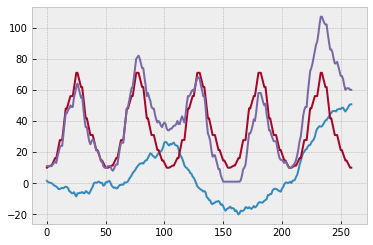

In [64]:
plt.plot(sj_resid_preds)
plt.plot(sj_monthly_preds)
plt.plot(sj_cases_pred)

In [65]:
# get monthly trend of whole test df
lr_iq_month = LinearRegression()
X_months = pd.get_dummies(df_iq['month'], prefix='month')[:520]
Xtest_months = pd.get_dummies(df_iq['month'], prefix='month')[520:]
y = cases_iq.values

lr_iq_month.fit(X_months, y)
monthly_trend = pd.Series(lr_iq_month.predict(X_months)).rolling(8, min_periods=1).mean()
iq_residuals_all = y - monthly_trend

# create test df of rolling weather stats
# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 52).mean()[52:520]
Xtrain_means2 = df_iq['reanalysis_specific_humidity_g_per_kg'].rolling(window = 52).mean()[52:520]
Xtrain_means3 = df_iq['reanalysis_dew_point_temp_k'].rolling(window = 52).mean()[52:520]
Xtrain_means4 = df_iq['ndvi_se'].rolling(window = 52).mean()[52:520]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1,Xtrain_means2,Xtrain_means3], axis = 1)

#Xtrain[Xtrain.columns] = scaler.fit_transform(Xtrain)

ytrain = iq_residuals_all[52:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_iq['station_avg_temp_c'].rolling(window = 52).mean()[520:]
Xtest_means2 = df_iq['reanalysis_specific_humidity_g_per_kg'].rolling(window =52).mean()[520:]
Xtest_means3 = df_iq['reanalysis_dew_point_temp_k'].rolling(window =52).mean()[520:]
Xtest_means4 = df_iq['ndvi_se'].rolling(window =52).mean()[520:]




# combine all dfs
Xtest_weather = pd.concat([Xtest_means1,Xtest_means2,Xtest_means3], axis = 1)
#Xtest_weather[Xtest_weather.columns] = scaler.fit_transform(Xtest_weather)

# fit on model
lr_iq_resid = LinearRegression()
lr_iq_resid.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [66]:
# make predictions on monthly data and residual data
iq_monthly_preds = pd.Series(lr_iq_month.predict(Xtest_months)).rolling(8, min_periods=1).mean()
iq_resid_preds = lr_iq_resid.predict(Xtest_weather)
iq_cases_pred = pd.Series(iq_monthly_preds + iq_resid_preds)
iq_cases_pred = iq_cases_pred.apply(lambda x: 0 if x < 1 else int(x))

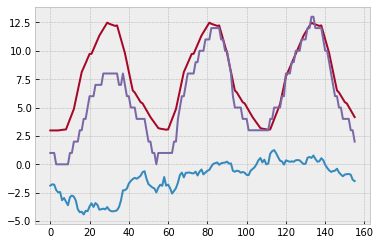

In [67]:
plt.plot(iq_resid_preds)
plt.plot(iq_monthly_preds)
plt.plot(iq_cases_pred)

In [68]:
total_preds = list(sj_cases_pred) + list(iq_cases_pred)

In [69]:
# submission
submission_format = pd.read_csv('./datasets/submission_format.csv')

In [70]:
submission_format['total_cases'] = total_preds

submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))
submission_format_only_cases = submission_format['total_cases']

In [71]:
# Save to CSV, use current date
submission_format.to_csv('submissions/try_fake_submission_27_1_05_18v2.csv', index=False)
submission_format_only_cases.to_csv('submissions/only_cases_27_1_05_18v2.csv', index=False)

In [72]:
submission_format.head(10)

,city,year,weekofyear,total_cases
0,sj,2008,18,11
1,sj,2008,19,11
2,sj,2008,20,11
3,sj,2008,21,11
4,sj,2008,22,11
5,sj,2008,23,12
6,sj,2008,24,13
7,sj,2008,25,14
8,sj,2008,26,13
9,sj,2008,27,17
